# Looking at effets of changing analysis parameters
The notebook shows how the main analysis parameters:
* $L$ = correlation length (can be horizontal, vertical or temporal);     
* $\epsilon^2$ = noise-to-signal ratio;     

influence the resulting interpolated field.

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics

## Data reading
From a netCDF file containing salinity measurements in the Provençal Basin.

In [2]:
varname = "Salinity"
filename = "../data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download", filename)
else
    @info "File already downloaded"
end

┌ Info: File already downloaded
└ @ Main In[2]:7


In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64, filename, "Salinity");

## Topography and grid definition

See the notebook on [bathymetry](../Diva-Workshops/06-topography.ipynb) for more explanations about the bathymetry preparation.

In [4]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(lonr,latr)

bathname = "../data/gebco_30sec_4.nc"

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[4]:12


In [5]:
bx,by,b = load_bath(bathname,true,lonr,latr)

mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

### Data selection for example

Cross validation, error calculations etc. assume independant data.     
Hence we do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range.     
For this example we select data from August data near surface (depth between 0 and 1 m).

In [6]:
sel = (obsdepth .< 1) .& (Dates.month.(obstime) .== 8)

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsids = obsid[sel];
@show (size(obsval))
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

size(obsval) = (1956,)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


## Analysis
### Simple analysis
The function to call is `DIVAndrun`:
```
fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),
            len,epsilon2;alphabc=0);
```
where 
Analysis `fi` using mean data as background.        
Structure `s` is stored for later use.     

* `mask` is the land-sea mask,     
* `(pm,pn)` are the metrics (inverse of resolution)     
* `(xi,yi)` is the grid on which the interpolation is performed.   

These 3 inputs were created before using `DIVAnd_rectdom`.

* `(obslon,obslat)` are the positions of the observations, obtained using `loadobs` (beginning of this notebook).     
* `obsval.-mean(obsval)` is the data anomalies (observations minus mean value).

`len` (correlation length) and `epsilon2` (noise-to-signal ratio) are the main two analysis paramerers that we will test hereinafter.

### Loop on the parameters
Here a loop on different values for $L$ and $\epsilon^2$.     
⚠️ Don't forget to add back the mean value when plotting the results (`fi.+mean(obsval)`).

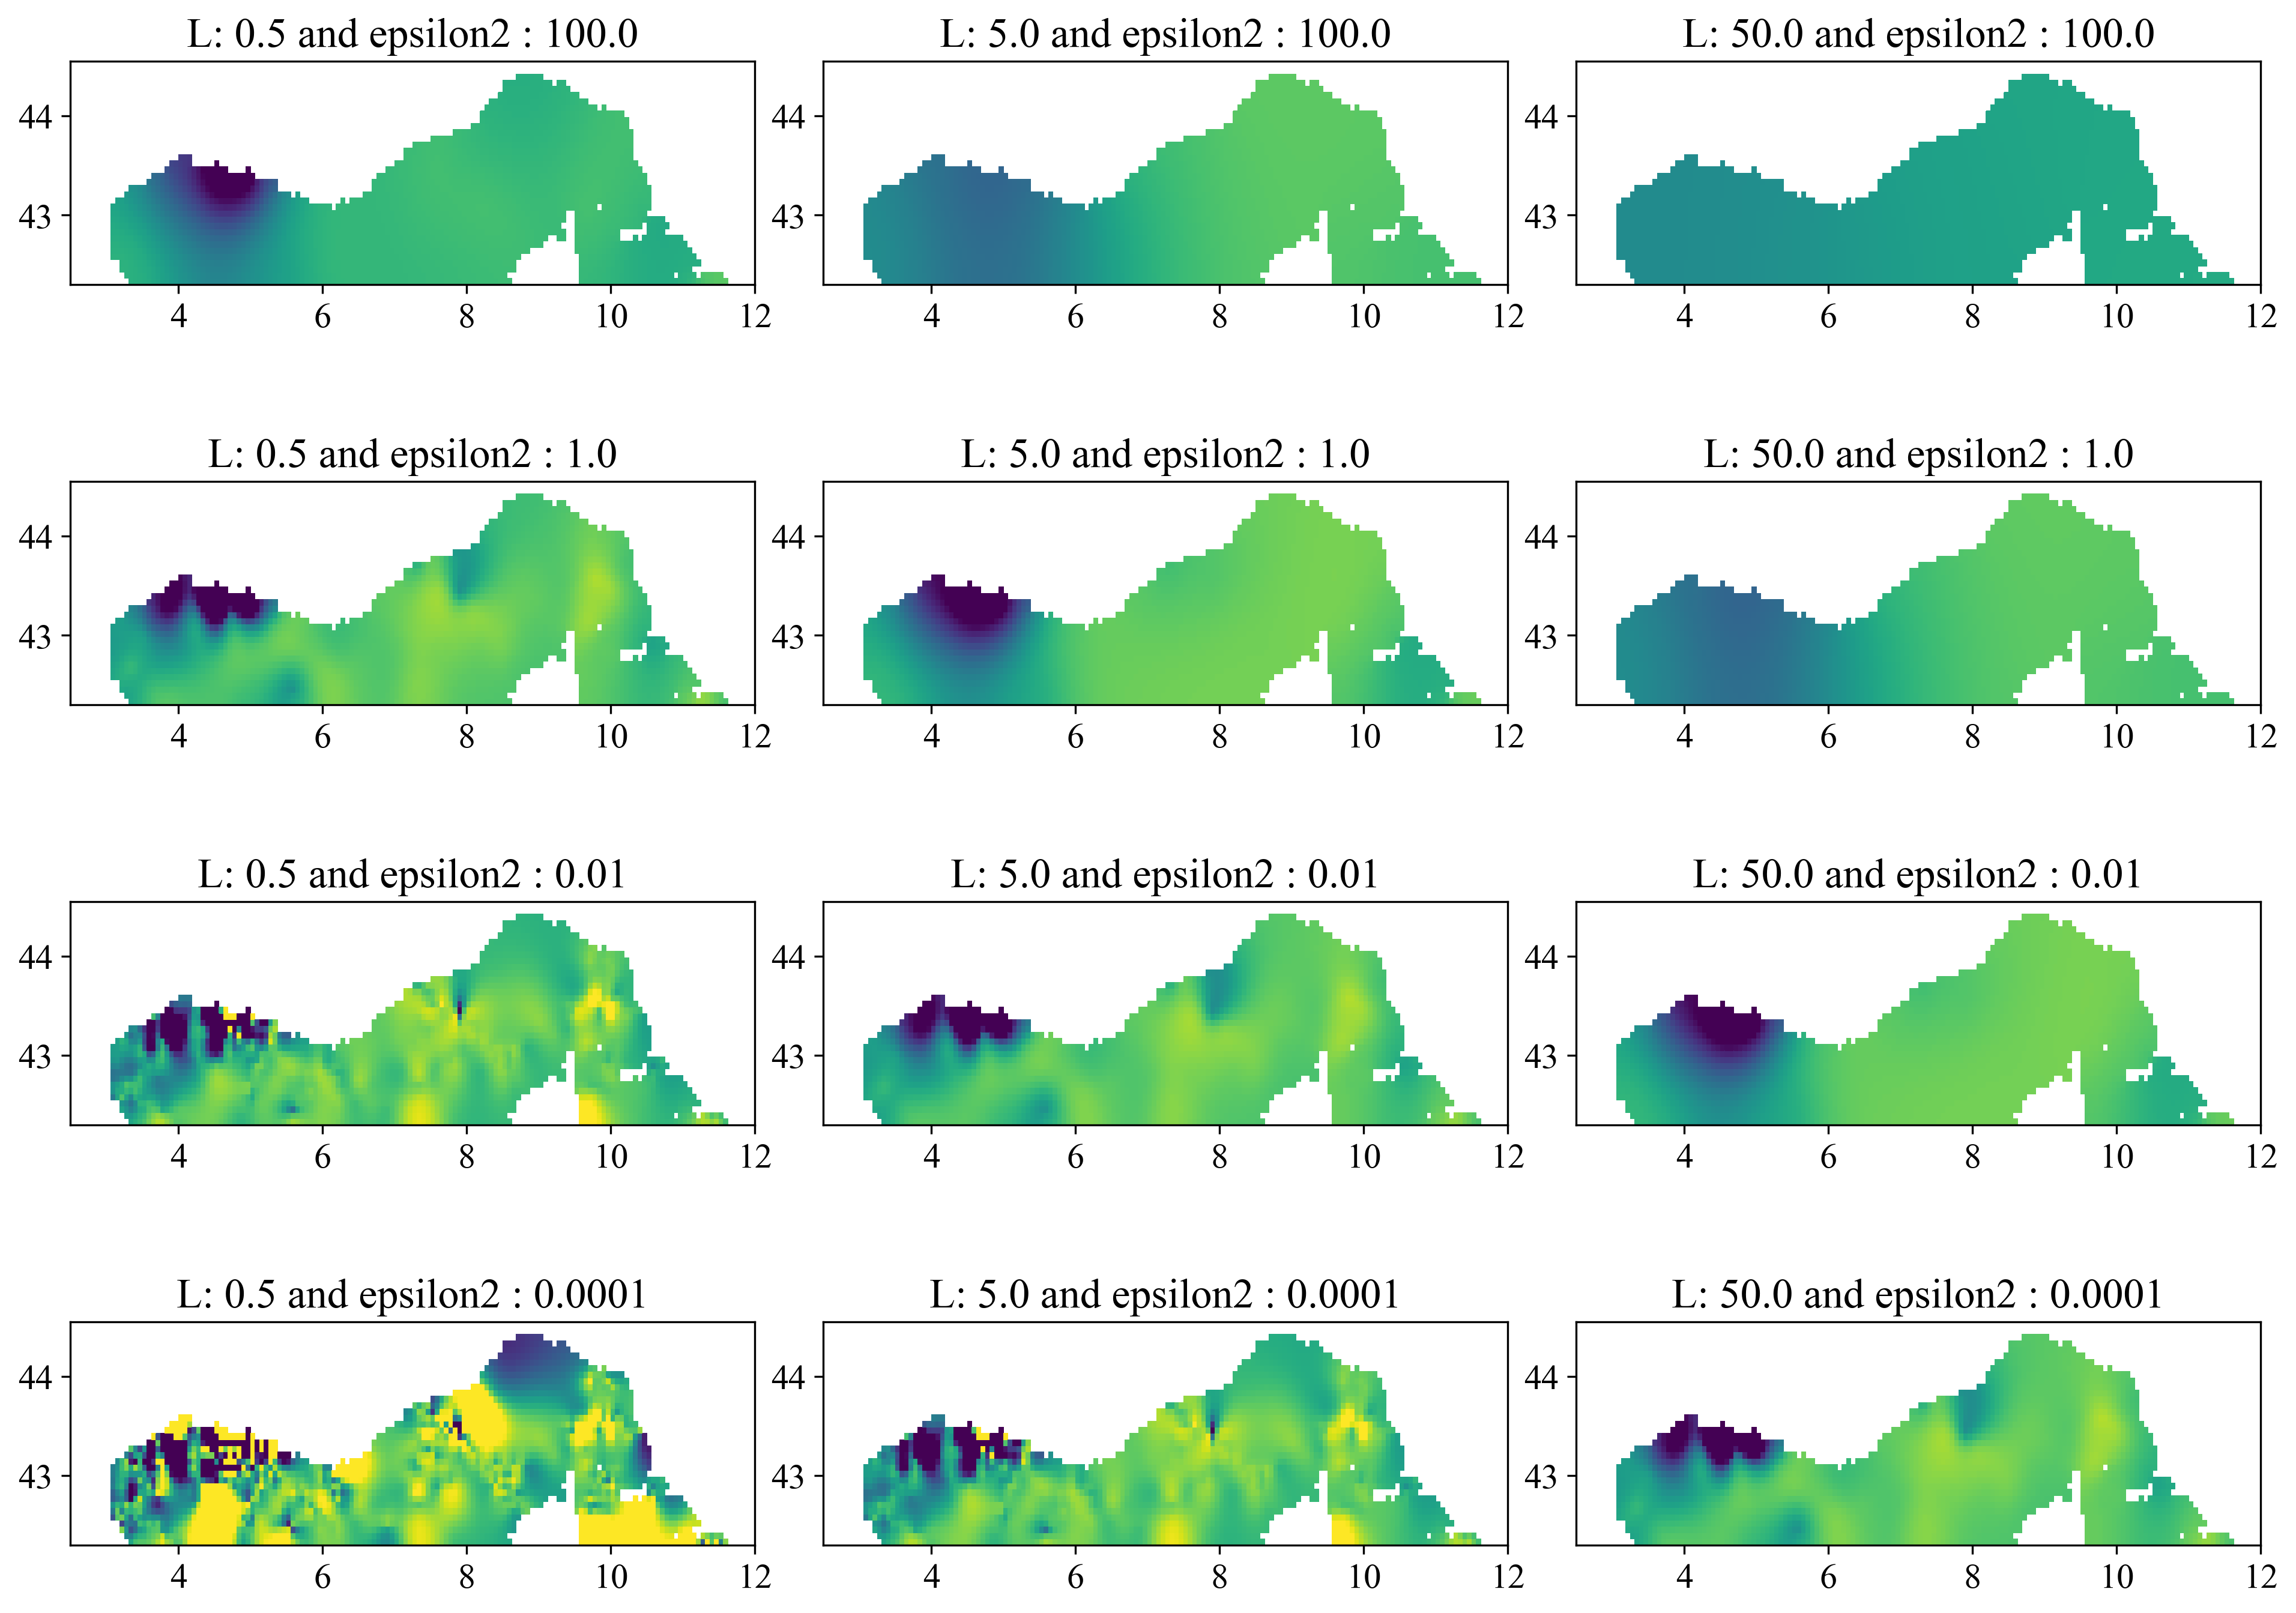

In [7]:
subplots_adjust(left = 0.1, bottom = 0.1, right = 2, top = 2, wspace = 0.1, hspace = 0.1)
for i=1:3
    for j=0:3
        len=5*10.0^(i-2)
        epsilon2=10.0^(-2*j+2)
        #@show i,j,len*sqrt(epsilon2),len,epsilon2
        fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),
            len,epsilon2;alphabc=0);
        subplot(4,3,3*j+i)
        pcolor(xi,yi,fi.+mean(obsval),vmin=37,vmax=38.5);#colorbar(orientation="horizontal")
        gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
        title("L: $len and epsilon2 : $epsilon2") 
    end
end

## But which combination to use ?

Visual inspection tells you which analyses are obvisouly (?) too noisy or too smooth.     
Also some suspect data points are seen when $L$ and $\epsilon^2$ are small.     
Let's create some figures showing the analysis, data values and residuals.

### Data values over analysis

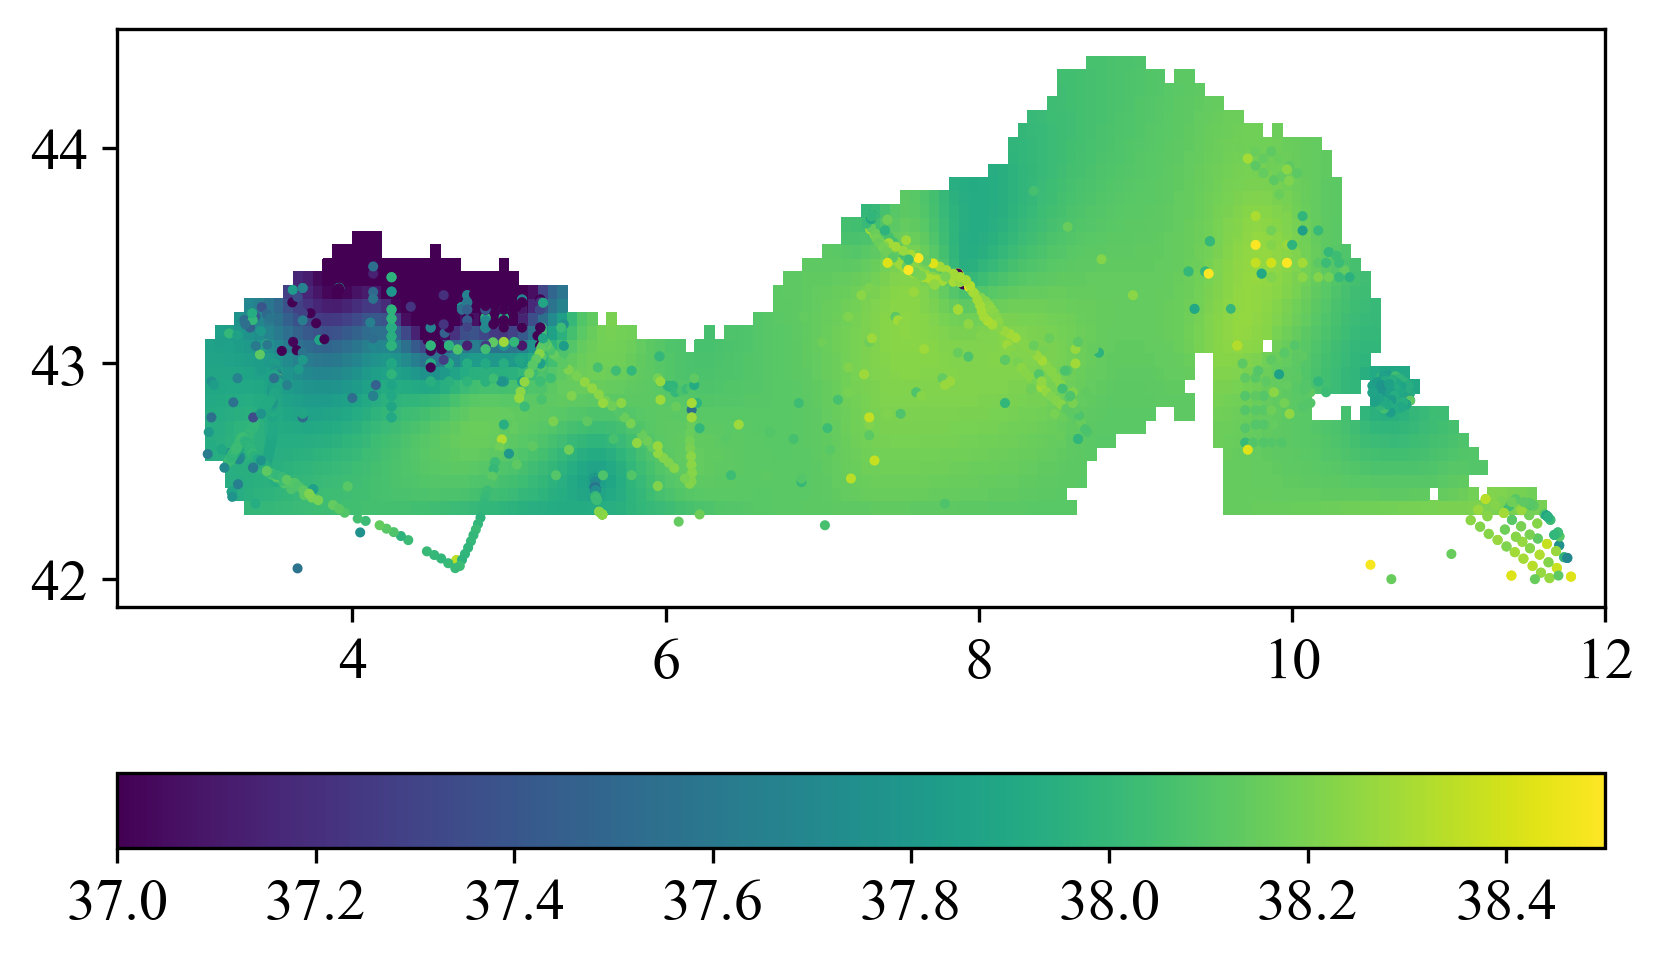

0.9951616449902039

In [8]:
figure()
len=1
epsilon2=1
fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2);

pcolor(xi,yi,fi.+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
scatter(obslon,obslat,s=2,c=obsval,vmin=37,vmax=38.5)
rscale=sqrt(var(obsval))

### Residuals
We get them using `DIVAnd_residualobs`.

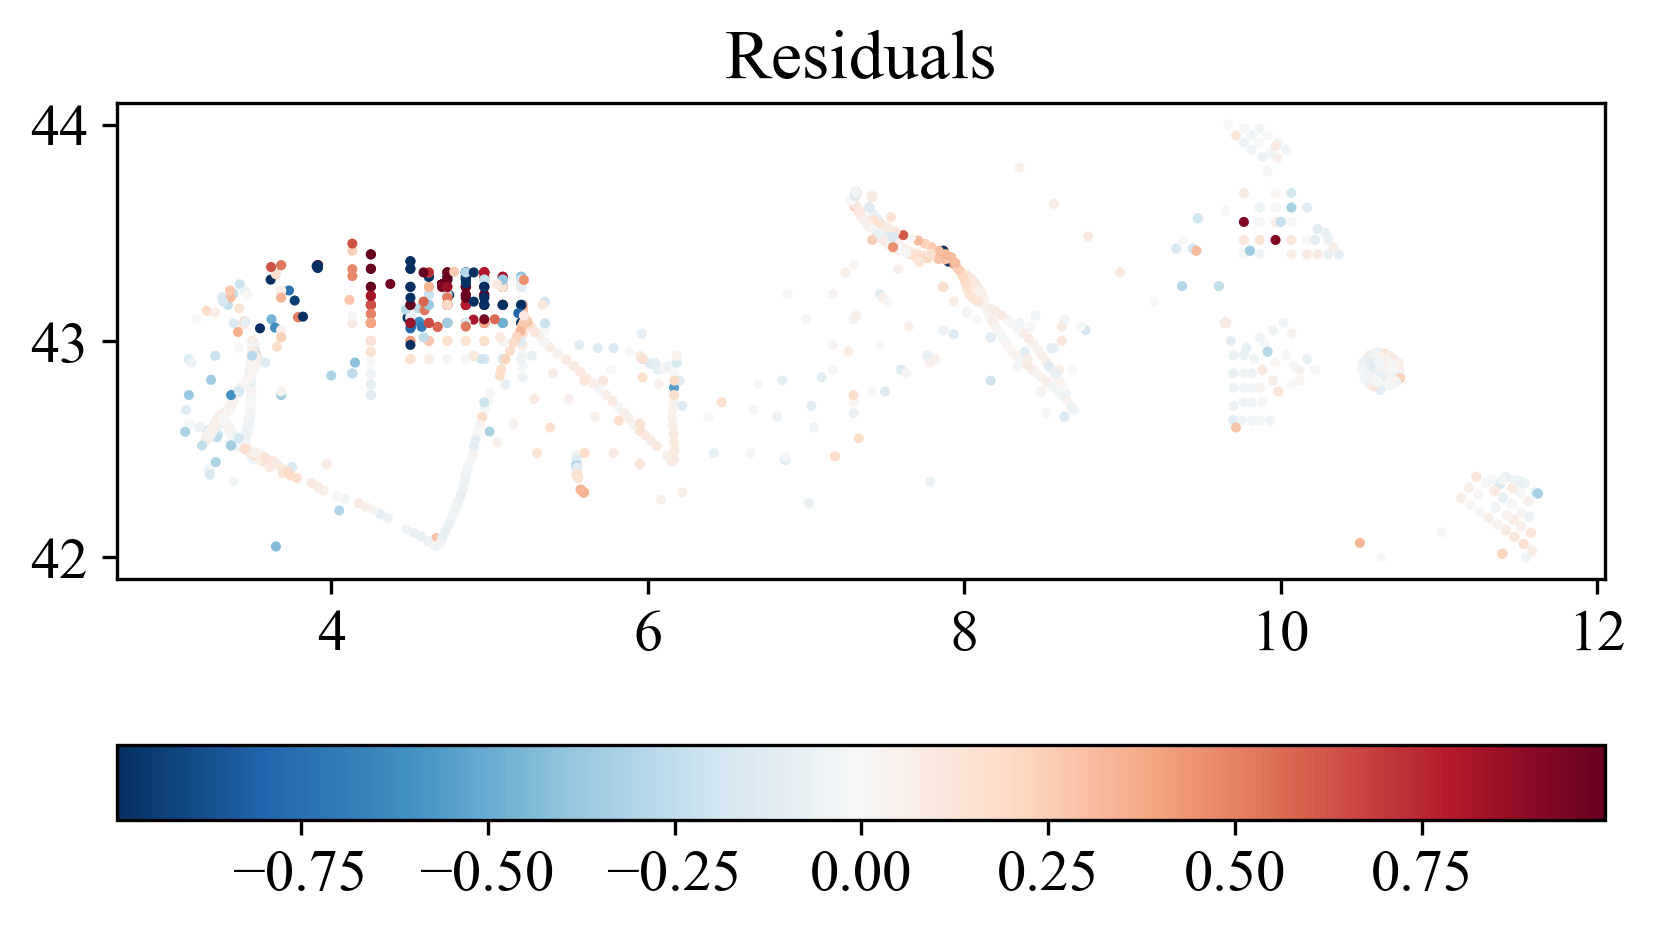

PyObject Text(0.5, 1, 'Residuals')

In [9]:
dataresiduals=DIVAnd_residualobs(s,fi)

figure()
scatter(obslon,obslat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale,cmap=ColorMap("RdBu_r"));
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
title("Residuals")

### Observed values vs. residuals

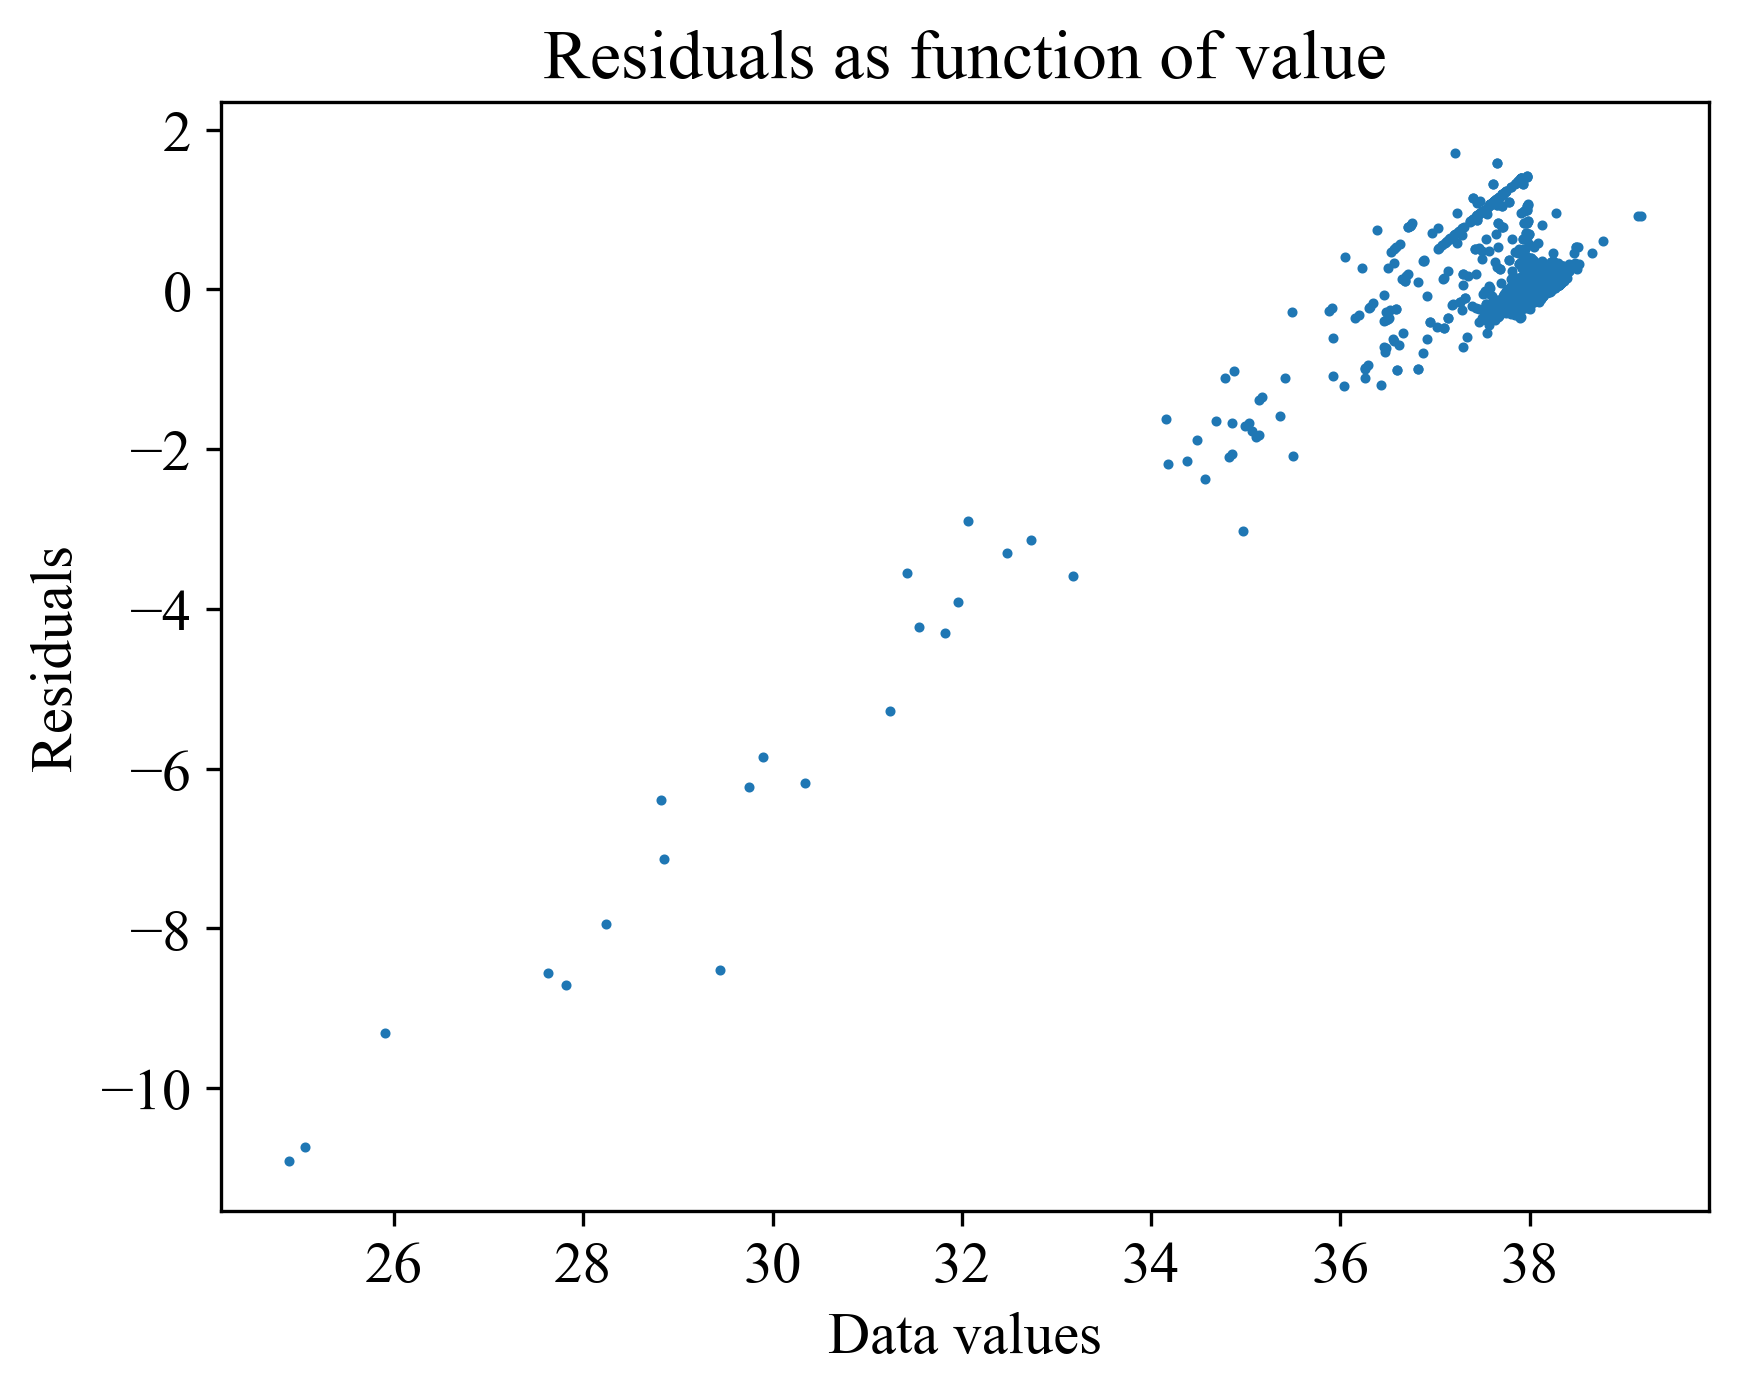

In [10]:
figure()
scatter(obsval,dataresiduals, s=2)
xlabel("Data values")
ylabel("Residuals")
title("Residuals as function of value");


Note how residuals change (decrease if you decrease $\epsilon^2$). 

**⚠️⚠️ low residuals are not necessarily a good sign as the analysis used the data points to which you compare your analysis.**

In [12]:
var(dataresiduals),var(obsval),var(fi[(fi.!==NaN)])

(NaN, 0.9903466996596086, 0.14421191559233523)

# Exercise

Change parameters $L$ or $\epsilon^2$ and see what happens (do not rerun the whole notebook, just the last cells)

# ⚠️ Important take-home message!
Remember Analyses are not very sensitive to changes in $L$ or $\epsilon^2$ if (in 2D) $L$ $\sqrt{\epsilon^2}$ remains constant and data coverage is reasonable.     
To see changes in the analysis you need significant changes in  $L$ or $\epsilon^2$ changing $L$ $\sqrt{\epsilon^2}$.         A few percent changes on the parameters does not really modify things even if $L$ $\sqrt{\epsilon^2}$ changes.